In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Ruta Raiz
PATH = "/content/drive/My Drive/RetoDotCSV"

# Ruta datos de entrada, de salida y de checkpoints
INPATH = PATH + '/generated_data'
OUTPATH = PATH + '/generated_fixed'
CKPATH = PATH + '/checkpoints'
BUFFER_SIZE = 400

imgurls = !ls -1 "{INPATH}"

n = 24
train_n = round(n * 0.80)

# Listado randomizado
randurls = np.copy(imgurls)

#np.random.seed(23)
np.random.shuffle(randurls)

# Particion train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

24 19 5


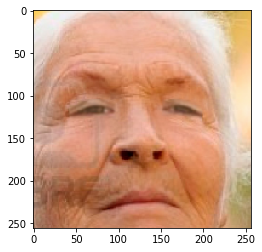

In [6]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imágenes
def resize(inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])
  
  return inimg, tgimg

def normalize(inimg, tgimg):
  inmg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1
  
  return inimg, tgimg

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 143 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  stacked_image = tf.stack([input_image, real_image], axis = 0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  input_image, real_image = cropped_image[0], cropped_image[1]
  
  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

def load_image(filename, augment=True):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/'+ filename)), tf.float32)[..., :3] # [256x256, Para limitar a 3 canales]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/'+ filename)), tf.float32)[..., :3]

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
    
  inimg, tgimg = normalize(inimg, tgimg)
  
  return inimg, tgimg
  
def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

plt.imshow(((load_train_image(randurls[0])[1]) + 1) / 2)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1) # Distribuir datos en N lotes

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(1)

#for inimg, tgimg in train_dataset.take(5):
#  plt.imshow(((tgimg[0,...]) + 1) / 2)
#  plt.show()


In [8]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  
  # Capa convolucional 
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer = initializer,
                    use_bias=False))
  
  # Capa de BatchNorm.
  if apply_batchnorm:
    result.add(BatchNormalization())
  
  # Capa de activacion
  result.add(LeakyReLU())
  
  return result

downsample(64)


In [9]:
def upsample(filters, apply_dropout=False):
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  # Capa convolucional 
  result.add(Conv2DTranspose(filters,
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))
  
  # Capa de BatchNorm.
  result.add(BatchNormalization())
  
  if apply_dropout:
    result.add(Dropout(0.5))
  
  # Capa de activacion
  result.add(ReLU())
  
  return result

upsample(64)

In [0]:
# Diseñando una U-Net para unir decoder y encoder
def Generator():
  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  
  down_stack = [
      downsample(64, apply_batchnorm=False),
      downsample(128),
      downsample(256),
      downsample(512),
      downsample(512),
      downsample(512),
      downsample(512),
      downsample(512),
  ]
  
  up_stack = [
      upsample(512, apply_dropout=True),
      upsample(512, apply_dropout=True),
      upsample(512, apply_dropout=True),
      upsample(512),
      upsample(256),
      upsample(128),
      upsample(64),
  ]
  
  initializer = tf.random_normal_initializer(0, 0.02)

  last = Conv2DTranspose(filters = 3,
                         kernel_size=4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh") # tanh va de -1 a 1
  x = inputs
  s = [] # skip connections
  
  concat = Concatenate()
  
  for down in down_stack:
    x = down(x)
    s.append(x)
    
  s = reversed(s[:-1]) # Hasta el penultimo elemento
    
  for up, sk in zip(up_stack, s):
    x = up(x)
    x = concat([x, sk])
    
  last = last(x)
  
  return Model(inputs=inputs, outputs=last)

generator = Generator()

In [0]:
def Discriminator():
  ini = Input(shape = [None, None, 3], name = "input_img")
  gen = Input(shape = [None, None, 3], name = "gener_img")
  
  con = concatenate([ini, gen])
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  down1 = downsample(64, apply_batchnorm = False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)  
  
  conv = tf.keras.layers.Conv2D(filters = 1,
                                kernel_size = 4, 
                                strides = 1,
                                kernel_initializer = initializer,
                                padding = "same")(zero_pad1)
  
  batchnorm1 = BatchNormalization()(conv)

  leaky_relu = LeakyReLU()(batchnorm1)

  zero_pad2 = ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()

In [0]:
# Funcion de costo para poner a competir al Gen/Disc
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss

In [0]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  
  return total_gen_loss

In [0]:
import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [0]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/output/' + save_filename + ".jpg", prediction[0,...])
    
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
      
  plt.show()

In [0]:
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)
    output_trg_discr = discriminator([target, input_image], training=True)

    disc_loss = discriminator_loss(output_trg_discr, output_gen_discr)
    gen_loss = generator_loss(output_gen_discr, output_image, target)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [0]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    img1 = 0
    
    for input_image, target in dataset:
      print("epoch" + str(epoch) + ' - train: ' + str(img1) + '/' + str(len(tr_urls)))
      img1 += 1
      train_step(input_image, target)
      clear_output(wait = True)
    
    img1 = 0
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(img1) + "_" + str(epoch), display_imgs=True)
      img1 += 1
    
    # Saving checkpoints
    if (epoch + 1) % 200 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


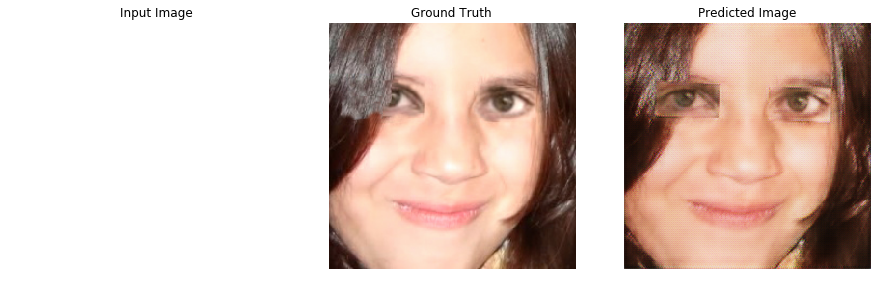

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


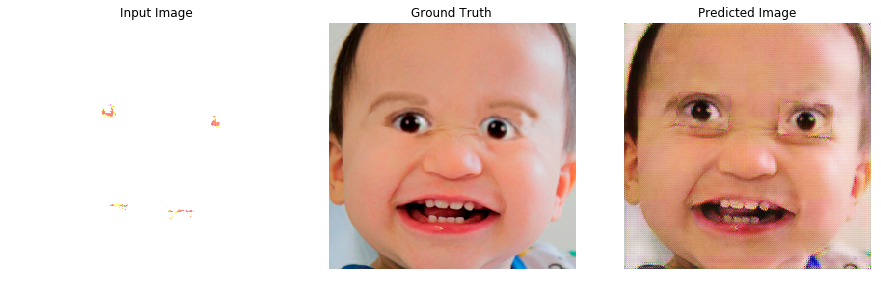

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


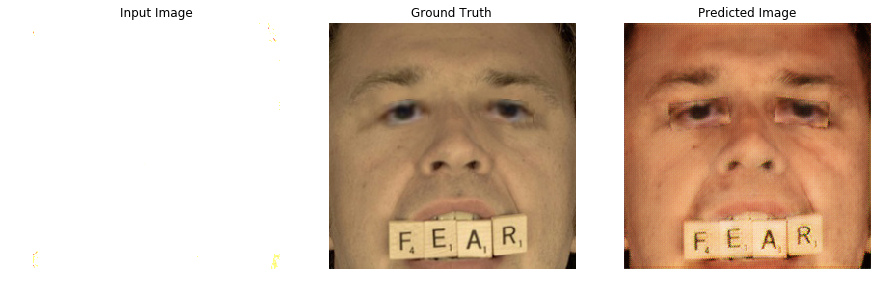

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


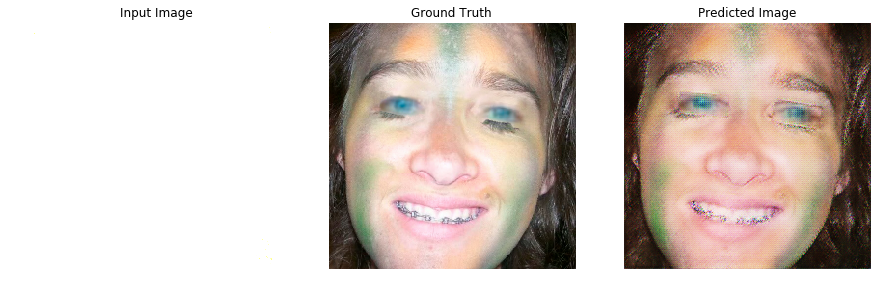

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


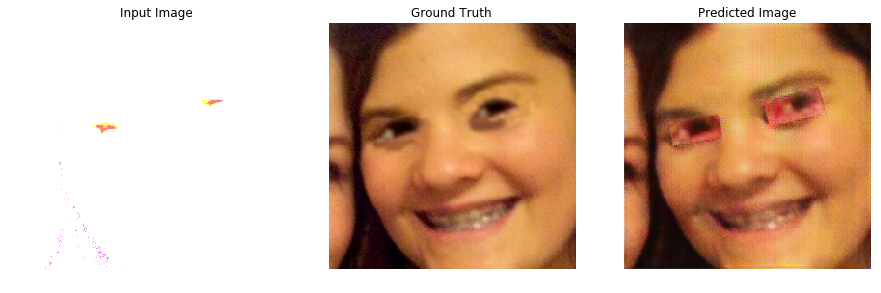

In [19]:
train(train_dataset, 100)